<a href="https://colab.research.google.com/github/CatXp0/reviewBERT/blob/main/ReviewBERT_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalam pachetul transformers, dezvoltat de Hugging Face
!pip install -qq transformers
# instalam pachetul demoji, care este utilizat pentru a lucra cu emoji-uri in text
!pip install -qq demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.7 MB/s eta 0:00:00


In [ ]:
# importam bibliotecile
import transformers
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import re, string
import demoji

from transformers import BertTokenizerFast, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch import nn
from collections import defaultdict
from textwrap import wrap
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# verificam device-ul pe care se va efectua calculul tensorilor atunci cand folosim pytorch
# se verifica daca un gpu este disponibil si, daca este, il va folosi pentru calcule. Altfel, va folosi cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# folosim modelul de pe hugging face https://huggingface.co/readerbench/RoBERT-base
PRE_TRAINED_MODEL_NAME = 'readerbench/RoBERT-base';

# Data processing

In [ ]:
# incarcam feedback-urile din csv
val_data = pd.read_csv('/content/product_reviews_export.csv', delimiter=';')
val_data.head()

<ipython-input-110-9b2bc2a60194>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(val_data, x='rating', y='gpt_rating', inner='box', palette='Dark2')


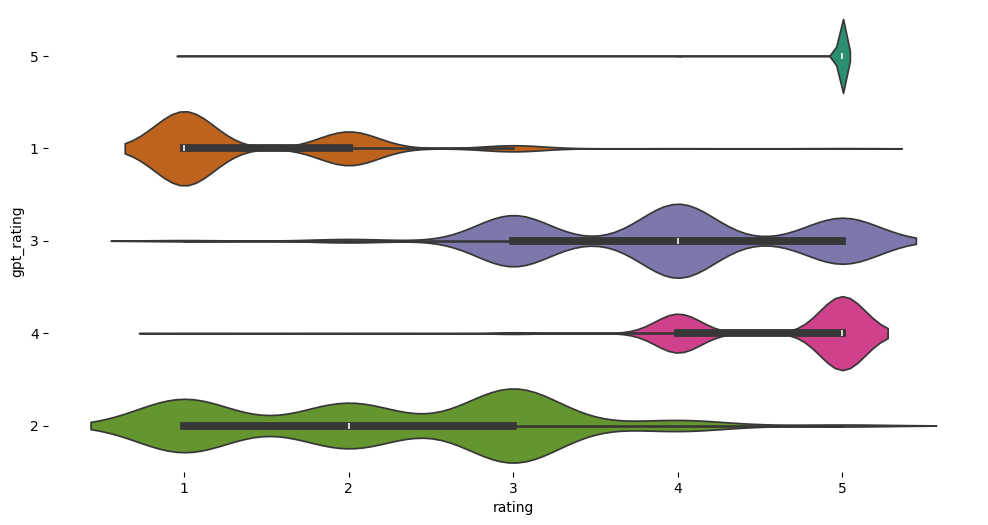

In [ ]:
# @title gpt_rating vs rating

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(val_data['gpt_rating'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(val_data, x='rating', y='gpt_rating', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15825 entries, 0 to 15824
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 15825 non-null  int64 
 1   source             15825 non-null  object
 2   review_id          15825 non-null  int64 
 3   product_id         15825 non-null  int64 
 4   review             15825 non-null  object
 5   title              15823 non-null  object
 6   rating             15825 non-null  int64 
 7   gpt_rating         15825 non-null  int64 
 8   source_created_at  15825 non-null  object
 9   source_updated_at  15825 non-null  object
 10  created_at         15825 non-null  object
 11  updated_at         15825 non-null  object
dtypes: int64(5), object(7)
memory usage: 1.4+ MB


In [ ]:
# stergem duplicatele din coloana review
val_data.drop_duplicates(subset='review',inplace=True)

In [ ]:
val_data.shape

(10302, 12)

In [ ]:
# cleanup diacritice
def cleanup_text(text):
  text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ')
  text = text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș")
  return text

def cleanup_emoji(text):
  return demoji.replace(text, '')

In [ ]:
# curatam textul de diacritice gresite si emoji-uri
texts_new = []
for t in val_data.review:
  newTxt = cleanup_text(cleanup_emoji(str(t)));
  newTxt = newTxt[:512]
  texts_new.append(newTxt)

val_data['text_clean'] = texts_new

ratings = []
for s in val_data.gpt_rating:
  ratings.append(str(s))

# mapam rating-ul de tip string 1,2,3,4,5 la 0,1,2,3,4 pentru a putea lucra cu ea
val_data['gpt_rating'] = ratings
val_data['score'] = val_data['gpt_rating'].map({'1':0,'2':1,'3':2,'4':3,'5':4})
val_data.info()

# stergem feedback-urile cu 0 litere
val_data = val_data[val_data['text_clean'] != ""].reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10301 entries, 0 to 10300
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 10301 non-null  int64 
 1   source             10301 non-null  object
 2   review_id          10301 non-null  int64 
 3   product_id         10301 non-null  int64 
 4   review             10301 non-null  object
 5   title              10300 non-null  object
 6   rating             10301 non-null  int64 
 7   gpt_rating         10301 non-null  object
 8   source_created_at  10301 non-null  object
 9   source_updated_at  10301 non-null  object
 10  created_at         10301 non-null  object
 11  updated_at         10301 non-null  object
 12  text_clean         10301 non-null  object
 13  score              10301 non-null  int64 
 14  text_len           10301 non-null  int64 
dtypes: int64(6), object(9)
memory usage: 1.2+ MB


In [ ]:
val_data['text_clean'].head()

0                          Foarte multumita de produs!
1    Fata de alte șervețele de pe piata, de la care...
2    Nu recomand persoanelor cu tenul sensibil. M-a...
3    Curata foarte bine și machiajul rezistent la a...
4    Servetele fine, placute, destul de umede, pent...
Name: text_clean, dtype: object

In [ ]:
text_len = []
for text in val_data.text_clean:
  review_length = len(text)
  text_len.append(review_length)

val_data['text_len'] = text_len
val_data['text_len'].head()

0     27
1    156
2    143
3     85
4     96
Name: text_len, dtype: int64

<ipython-input-43-3a4790e96205>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=val_data[val_data['text_len']<10], palette='rocket')


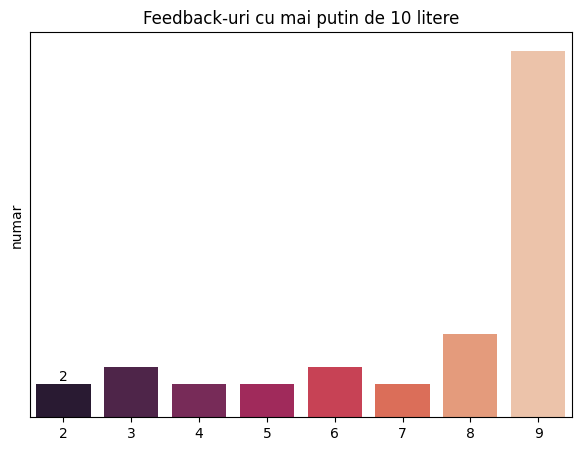

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=val_data[val_data['text_len']<10], palette='rocket')
plt.title('Feedback-uri cu mai putin de 10 litere')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('numar')
plt.xlabel('')
plt.show()

In [ ]:
val_data['rating'].value_counts() # pentru a vedea nr de feedback-uri pt fiecare clasa

rating
5    8324
4     751
1     497
3     437
2     292
Name: count, dtype: int64

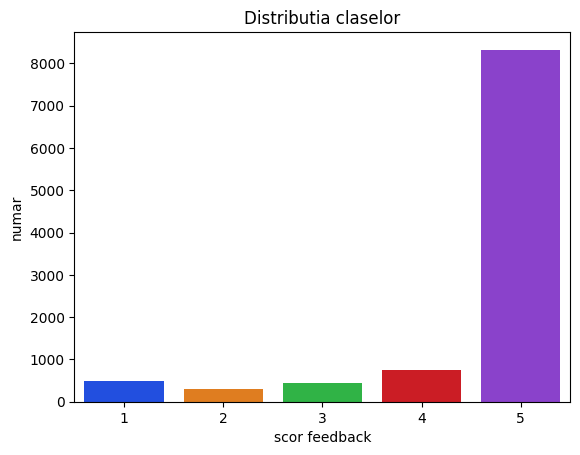

In [ ]:
sns.countplot(x='rating', data=val_data, palette='bright', hue='rating', legend=False)
plt.title('Distributia claselor')
plt.ylabel('numar')
plt.xlabel('scor feedback')
plt.show()

In [ ]:
# incercam sa corectam dezechilibrul de clase
# cream un RandomOverSampler pentru a gestiona suprasampling-ul datelor
ros = RandomOverSampler()
# convertim coloanele 'text_clean' si 'score' din val_data la array-uri numpy
# si le remodelam pentru a avea dimensiunea potrivită pentru funcția fit_resample
train_x, train_y = ros.fit_resample(
    np.array(val_data['text_clean']).reshape(-1, 1),
    np.array(val_data['score']).reshape(-1, 1));
# crearea un DataFrame pandas din datele suprasample-uite
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)),
                        columns = ['text_clean', 'score']);

# putem vedea nr pt fiecare valoare a scorului din DataFrame-ul train_os
train_os['score'].value_counts()

score
4    7697
0    7697
2    7697
3    7697
1    7697
Name: count, dtype: int64

In [ ]:
# initializam tokenizer-ul
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_txt = 'Culorile nu sunt foarte aprinse.'

# tokenizam o propozitie si o trecem prin model
input_ids = torch.tensor(tokenizer.encode(sample_txt)).unsqueeze(0)  # Batch size 1

# tokenizam datele
val_encodings = tokenizer(sample_txt, max_length=512, truncation=True)

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Input IDs: {token_ids}')
print(val_encodings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/245k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

 Sentence: Culorile nu sunt foarte aprinse.
   Tokens: ['culori', '##le', 'nu', 'sunt', 'foarte', 'aprins', '##e', '.']
Input IDs: [2034, 38, 24, 42, 114, 6014, 9, 513]
{'input_ids': [3, 2034, 38, 24, 42, 114, 6014, 9, 513, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Other

In [ ]:
# calculam numarul maxim de tokeni
token_lens = []

# tokenizam fiecare feedback si il bagam in lista token_lens
for txt in train_os['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=None, truncation=True)
    token_lens.append(len(tokens))

# determină lungimea maxima a secventelor de tokeni din lista folosind functia
# np.max din biblioteca numpy
max_len=np.max(token_lens)
print(f"Numarul maxim de tokeni: {max_len}")

Numarul maxim de tokeni: 151


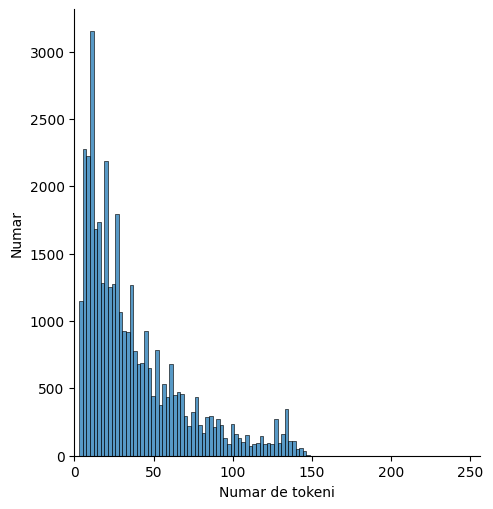

In [ ]:
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Numar de tokeni');
plt.ylabel('Numar');

In [ ]:
# setam un seed pt functiile numpy si torch, ca sa putem reproduce rezultatele
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# impartim datele in seturi de antrenament, test si validare
df_train, df_test = train_test_split(train_os, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((30788, 2), (3848, 2), (3849, 2))

In [ ]:
# dataset custom care gestionează feedbackurile si scorurile acestora
# Tokenizeaza textele si le converteste în tensori PyTorch
class ReviewDataset(Dataset):
  # constructorul
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets # scorurile asociate feedback-urilor
    self.tokenizer = tokenizer
    self.max_len = max_len # lungimea maxima pt tokenizare

  # metoda pt a obtine lungimea datasetului
  def __len__(self):
    return len(self.reviews)

  # metoda pentru obtinerea unui element din dataset la indexul specificat item
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    # tokenizarea feedback-ului
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True, # adauga tokenii speciali CLS si SEP
      max_length=self.max_len, # trunchiază sau adauga PAD pana la lungimea max
      return_token_type_ids=False, # nu returnează id-uri pentru tipurile de token
      padding='max_length', # adauga padding la feedback pana la lungimea maximă
      return_attention_mask=True, # returnează masca de atentie
      return_tensors='pt' # returnează tensorii în format pytorch.
    )

    return {
      'review_text': review,
      # id-urile tokenilor (flatten pentru a reduce la un singur vector)
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      # scorurile pt feedback convertit intr-un tensor PyTorch de tip long
      'targets': torch.tensor(target, dtype=torch.long)
    }

# creeaza un obiect DataLoader pentru dataset-ul dat
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df.text_clean.to_numpy(), # convertim feedbackul intr-un array numpy
    targets=df.score.to_numpy(), # convertim scorul la un array numpy
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size, # dimensiunea batchului pentru antrenament
    num_workers=4 # numarul de thread-uri pentru incarcarea datelor.
  )

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 256

# crearea DataLoader-elor pentru antrenament, validare si testare
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# extragem primul batch de date
data = next(iter(train_data_loader))
# afisam cheile din Afișează cheile din dictionarul data
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
# dimensiunile tensorului care conține id-urile tokenilor pentru fiecare recenzie din batch
print(data['input_ids'].shape)
# dimensiunile tensorului care conține masca de atenție pentru fiecare recenzie din batch
print(data['attention_mask'].shape)
# dimensiunile tensorului care contine scorurile pentru fiecare recenzie din batch
# acestea sunt etichetele asociate fiecarui feedback si sunt utilizate in timpul antrenarii modelului
print(data['targets'].shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


# Sentiment analysis

In [ ]:
# SentimentClassifier extinde clasa nn.Module din pytorch pentru a crea un model de clasificare
class SentimentClassifier(nn.Module):
  # constructor
  def __init__(self, n_classes):
    # apeleaza constructorul clasei parinte nn.Module.
    super(SentimentClassifier, self).__init__()
    # incarca un model BERT pre-antrenat
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    # adauga un strat de Dropout cu probabilitatea de 0.3 pentru regularizare
    # prevenind astfel overfitting-ul
    self.drop = nn.Dropout(p=0.3) # for regularization
    # adauga un strat linear de output care mapeaza iesirile BERT de dimensiune
    # hidden_size la numarul de clase (n_classes).
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    # adauga un strat Softmax pentru a normaliza iesirile la probabilitati
    # pe dimensiunea claselor
    self.softmax = nn.Softmax(dim=1)

  # metoda forward care defineste fluxul datelor prin retea
  def forward(self, input_ids, attention_mask):
    # trecerea tensorilor input_ids si attention_mask prin modelul BERT pentru a
    # obtine pooled_output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # aplicarea Dropout pe pooled_output
    output = self.drop(pooled_output)
    # aplicarea stratului linear pe output dupa Dropout pentru a obtine
    # logit-urile pentru fiecare clasa
    output = self.out(output)

    # aplicarea functiei Softmax pe logit-uri pentru a obtine probabilitatile
    # pentru fiecare clasa
    return self.softmax(output)

In [ ]:
class_names = ['1','2','3','4','5']

# initializam un obiect SentimentClassifier cu numarul de clase egal cu 5
model = SentimentClassifier(len(class_names))
# mutam modelul pe dispozitivul specificat (GPU sau CPU)
model = model.to(device)

In [ ]:
# mutam tensorul input_ids pe dispozitivul specificat
input_ids = data['input_ids'].to(device)
# mutam tensorul attention_mask pe dispozitivul specificat
attention_mask = data['attention_mask'].to(device)

# afiseaza dimensiunile tensorilor input_ids si attention_mask, care ar trebui
# sa fie de forma (batch_size, seq_length).
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 256])
torch.Size([32, 256])


In [ ]:
# executarea modelului
model(input_ids, attention_mask)

tensor([[0.1396, 0.4168, 0.1347, 0.1920, 0.1170],
        [0.2525, 0.1907, 0.2279, 0.1872, 0.1417],
        [0.2525, 0.3296, 0.0714, 0.2188, 0.1277],
        [0.2085, 0.1854, 0.2724, 0.1474, 0.1864],
        [0.1353, 0.2176, 0.3352, 0.1816, 0.1303],
        [0.3544, 0.1815, 0.1756, 0.1656, 0.1230],
        [0.1256, 0.1855, 0.2257, 0.2281, 0.2352],
        [0.2794, 0.1073, 0.1933, 0.1505, 0.2696],
        [0.2329, 0.1386, 0.2915, 0.2103, 0.1268],
        [0.2442, 0.1262, 0.1925, 0.1540, 0.2832],
        [0.2768, 0.2131, 0.1519, 0.2281, 0.1301],
        [0.2209, 0.2034, 0.1680, 0.1982, 0.2095],
        [0.2477, 0.2771, 0.2620, 0.1076, 0.1056],
        [0.1261, 0.2984, 0.2661, 0.1241, 0.1854],
        [0.2319, 0.2044, 0.1709, 0.2033, 0.1895],
        [0.1591, 0.2282, 0.3150, 0.1447, 0.1531],
        [0.2171, 0.1733, 0.3237, 0.1647, 0.1213],
        [0.1617, 0.1981, 0.3106, 0.2104, 0.1192],
        [0.1853, 0.2313, 0.2041, 0.2199, 0.1594],
        [0.2125, 0.3072, 0.0954, 0.2527, 0.1322],


# Training

In [ ]:
# nr de epoci pentru antrenarea modelului
EPOCHS = 4
# numarul total de pasi de antrenament, calculat ca nr de batch-uri per epoca
# inmulțit cu numarul de epoci
total_steps = len(train_data_loader) * EPOCHS

# Adam optimizer cu weight decay correction
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# scheduler care ajusteaza rata de invatare intr-un mod liniar
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0, # nr de pasi de warmup
  num_training_steps=total_steps # nr total de pasi de antrenament
)

# functia de pierdere (loss) pentru clasificare multi-clasa
# o mutam pe device
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# functia de antrenament
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  # setam modelul in modul de antrenament
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    # rulam modelul pe datele de intrare si obtinem outputurile
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # calculam predictiile
    _, preds = torch.max(outputs, dim=1)
    # calculam pierderea
    loss = loss_fn(outputs, targets)

    # actualizam nr de predictii corecte
    correct_predictions += torch.sum(preds == targets).detach().cpu().numpy()
    # adaugam pierderea la lista losses
    losses.append(loss.item())

    # facem backward propagation
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # actualizam parametrii modelului folosind optimizatorul si scheduler-ul
    optimizer.step()
    scheduler.step()
    # resetam gradientele.
    optimizer.zero_grad()

  # returneaza acuratetea si pierderea medie pentru epoca
  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  # seteaza modelul in modul de evaluare
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      # rulam modelul pe datele de intrare si obtinem outputurile
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # calculam predictiile si pierderea.
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      # actualizam nr de predictii corecte si adaugam pierderea la lista losses.
      correct_predictions += torch.sum(preds == targets).detach().cpu().numpy()
      losses.append(loss.item())

  # returneaza acuratetea si pierderea medie pentru epoca
  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
# antrenarea si evaluarea modelului
%%time

# initializam un dictionar pentru stocarea istoricului antrenamentului si evaluarii
history = defaultdict(list)
# cea mai buna acuratete, 0 initial
best_accuracy = 0

for epoch in range(EPOCHS):

  # afisam nr epocii din total
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # apelam train_epoch pentru a antrena modelul pe setul de date de antrenament
  # se returneaza acuratetea si pierderea medie
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  # le afisam
  print(f'Train loss {train_loss} accuracy {train_acc}')

  # apelam eval_model pentru a evalua modelul pe setul de date de validare si
  # se returneaza acuratetea si pierderea medie.
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  # le afisam
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  # stocam acuratetea si pierderea pentru antrenament si validare in dict history
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # salvează starea modelului daca acuratețea pe setul de validare este cea mai
  # buna de pana acum
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 1.1788966437242732 accuracy 0.7227491230349486
Val   loss 1.0642976893866358 accuracy 0.8404365904365905

Epoch 2/4
----------
Train loss 1.0357998370010162 accuracy 0.8689749252955697
Val   loss 1.0100627093275716 accuracy 0.8955301455301455

Epoch 3/4
----------
Train loss 1.0062931031452904 accuracy 0.898629336104976
Val   loss 0.9958563102178337 accuracy 0.9095634095634095

Epoch 4/4
----------
Train loss 0.9947939432174865 accuracy 0.9102572430817202
Val   loss 0.9952239719304171 accuracy 0.9106029106029107

CPU times: user 14min 27s, sys: 6min 36s, total: 21min 4s
Wall time: 21min 3s


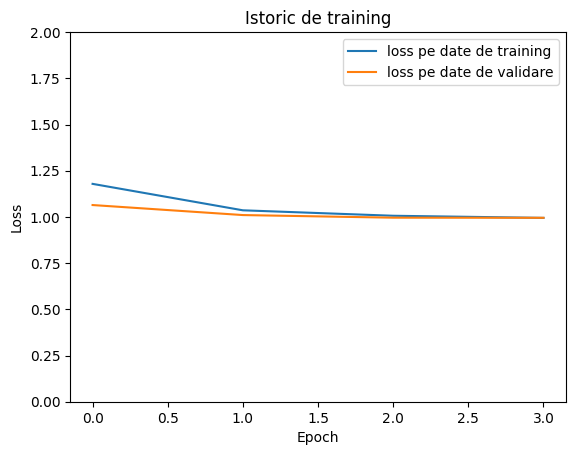

In [ ]:
plt.plot(history['train_loss'], label='loss pe date de training')
plt.plot(history['val_loss'], label='loss pe date de validare')

plt.title('Istoric de training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2]);

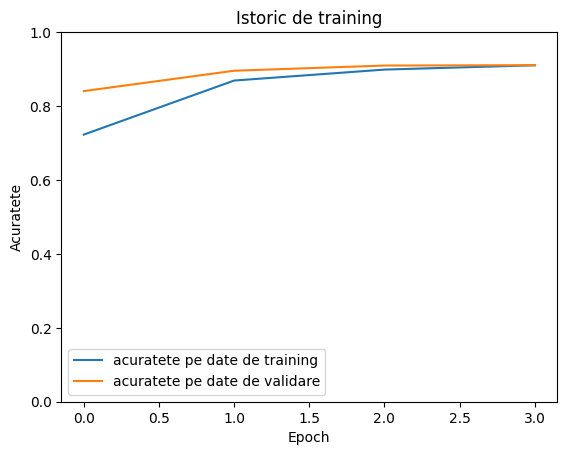

In [ ]:
plt.plot(history['train_acc'], label='acuratete pe date de training')
plt.plot(history['val_acc'], label='acuratete pe date de validare')

plt.title('Istoric de training')
plt.ylabel('Acuratete')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Evaluation

In [ ]:
# evaluam performanta modelului pe setul de test
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

# afiseaza valoarea scalară a tensorului test_acc, care reprezintă acuratețea pe setul de test.
test_acc.item()

0.9004936347103144

In [ ]:
# functia pentru obtinerea predictiilor
def get_predictions(model, data_loader):
  # seteaza modelul in modul de evaluare, dezactivand dropout-ul si alte mecanisme de antrenament.
  model = model.eval()

  # initializarea listelor pentru stocarea rezultatelor
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  # context manager pentru a dezactiva calculul gradientului
  # economisim astfel memorie si acceleram procesarea
  with torch.no_grad():
    # trecem prin DataLoader pentru a obtine predictiile
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      # rulam modelul pe datele de input
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # obtinem predictiile prin aplicarea functiei torch.max pe outputuri
      _, preds = torch.max(outputs, dim=1)

      # extindem listele cu valorile din batchul curent
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
# evaluarea modelului pe setul de test:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [ ]:
test_acc

0.9004936347103144

In [ ]:
test_loss

1.0039750411490764

In [ ]:
# obtinem predictiile
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
# afisam raportului de clasificare
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.92      0.96      0.94       746
           2       0.96      0.90      0.93       775
           3       0.91      0.90      0.90       771
           4       0.87      0.85      0.86       789
           5       0.86      0.90      0.88       768

    accuracy                           0.90      3849
   macro avg       0.90      0.90      0.90      3849
weighted avg       0.90      0.90      0.90      3849



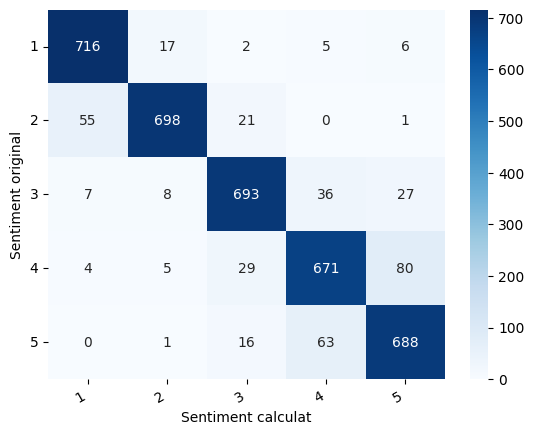

In [ ]:
# functie pentru afisarea matricei de confuzie
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Sentiment original')
  plt.xlabel('Sentiment calculat');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 10

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Sunt foarte mulțumit de acest șampon. Am încercat multe șampoane, dar
acesta este cel mai bun până acum.Îmi face părul să strălucească,
neted și mătăsos. Parul meu este vizibil mai sănătos cand folosesc
samponul asta. Nu pot decat sa il recomand. Nu este un sampon ieftin,
dar isi merita banii!️️️️

True sentiment: 4


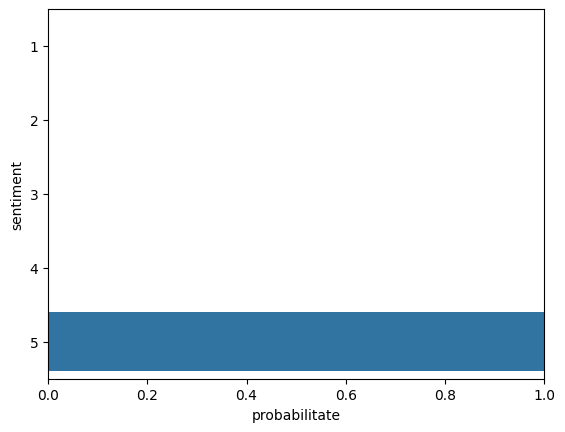

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probabilitate')
plt.xlim([0, 1]);

# TEST

In [1]:
review_text = "Am dat șamponul direct la gunoi, a fost super"
# tokenizam feedback-ul
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

# trecem inputul si attention mask prin model
output = model(input_ids, attention_mask)

# obtinem probabilitatile cu ajutorul functiei softmax
with torch.no_grad():
  probabilities = F.softmax(output, dim=1)

confidence, predicted_class = torch.max(probabilities, dim=1)
probabilities = probabilities.flatten().cpu().numpy().tolist()
predicted_class = predicted_class.cpu().item()
class_names_int = [eval(i) for i in class_names]
probabilities_plot = dict(zip(class_names_int, probabilities));

print(f'Feedback      : {review_text}')
print(f'Scor          : {class_names[predicted_class]}')
print(f'Probabilitati : {probabilities_plot}')

sns.barplot(x=list(probabilities_plot.keys()), y=list(probabilities_plot.values()), palette='bright', legend=False)
plt.ylabel('Probabilitate')
plt.xlabel(f'Scor feedback')

NameError: name 'tokenizer' is not defined

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


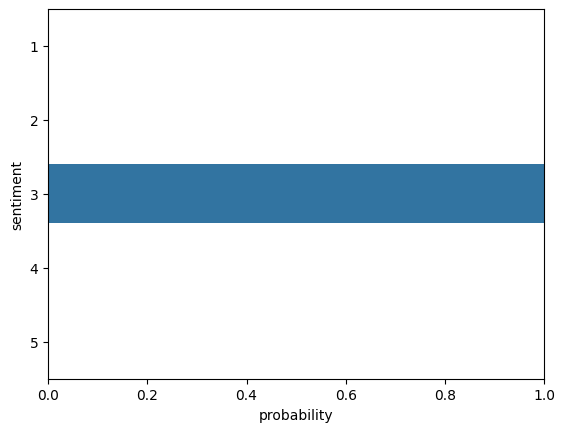

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);